Когда мы создаем объект из класса, атрибуты объекта будут храниться в словаре под названием ```__dict__```. Мы используем этот словарь для получения и установки атрибутов. Он позволяет нам динамически создавать новые атрибуты после создания объекта.
Давайте создадим простой класс Article, который изначально имеет 2 атрибута date и writer. Если мы выведем ```__dict__``` объекта, то получим ключ и значение каждого атрибута. Тем временем мы также выводим ```__dict__``` класса, который понадобится позже. После этого к объекту добавляется новый атрибут reviewer, и мы можем увидеть его в обновленном ```__dict__```.

In [36]:
class Article:
    def __init__(self, date, writer):
        self.date = date
        self.writer = writer
        
article = Article("2020-06-01","xiaoxu")
# список всех локальных свойств экземпляра класса хранится в его магическом списке ```__dict__```:
print(article.__dict__)
# {'date': '2020-06-01', 'writer': 'xiaoxu'}
print(Article.__dict__)
# {'__module__': '__main__', '__init__': <function Article.__init__ at 0x10d28f0e0>, 
#  '__dict__': <attribute '__dict__' of 'Article' objects>, '__weakref__': <attribute '__weakref__' of 'Article' objects>, 
#  '__doc__': None}
article.reviewer = "jojo"
print(article.__dict__)
# {'date': '2020-06-01', 'writer': 'xiaoxu', 'reviewer': 'jojo'}
print(article.reviewer)
# jojo


{'date': '2020-06-01', 'writer': 'xiaoxu'}
{'__module__': '__main__', '__init__': <function Article.__init__ at 0x1163f00e0>, '__dict__': <attribute '__dict__' of 'Article' objects>, '__weakref__': <attribute '__weakref__' of 'Article' objects>, '__doc__': None}
{'date': '2020-06-01', 'writer': 'xiaoxu', 'reviewer': 'jojo'}
jojo


## Достаточно хорошо?

Ну, мы не можем сказать, что это плохо, пока не найдем лучшее решение. Словарь является очень мощным инструментом в Python, но когда дело доходит до создания тысяч или миллионов объектов, мы можем столкнуться с некоторыми проблемами:
- Словарю нужна память. Миллионы объектов определенно съедят всю оперативную память.
- Словарь фактически является хэш-картой. Наихудший случай временной сложности get/set в хэш-карте - O(n). https://wiki.python.org/moin/TimeComplexity

Давайте познакомиимся со специальной коллекцией ```__slots__```

Из документации Python: ```__slots__``` позволяет нам явно объявлять члены данных (например, свойства) и запрещает создание ```__dict__``` , если dict явно не объявлен в ```__slots__``` или не доступен в родительском компоненте. 

Накладывает ограничения именно на локальные свойства объекта. А не на атрибуты класса.

Но как это связано с проблемами, которые мы затронули?

Давайте создадим класс ArticleWithSlots. Единственное различие между двумя классами - это дополнительное поле ```__slots__```.

In [3]:
class ArticleWithSlots:
    __slots__ = ["date", "writer"]

    def __init__(self, date, writer):
        self.date = date
        self.writer = writer

```__slots__``` создается на уровне класса, что означает, что если мы выведем ```ArticleWithSlots.__dict__```, мы сможем его увидеть. Кроме того, мы также видим 2 дополнительных атрибута на уровне класса, ```date: <member 'date' ..>``` и ```writer: <member 'writer' ..>```, которые принадлежат классу member_descriptor (это просто специальный варианты дескриптора).

In [ ]:
print(ArticleWithSlots.__dict__)
# {'__module__': '__main__', '__slots__': ['date', 'writer'], '__init__': <function ArticleWithSlots.__init__ at 0x103f6c290>, 
# 'date': <member 'date' of 'ArticleWithSlots' objects>, 'writer': <member 'writer' of 'ArticleWithSlots' objects>, 
#  '__doc__': None}
print(ArticleWithSlots.date.__class__)
# <class 'member_descriptor'>

В качестве значения ```__slots__``` может быть указана строка, объект поддерживающий итерирование, или последовательность строк с именами атрибутов, для использования экземплярами.

Слоты реализуются при помощи создания дескриптора для каждого из перечисленных атрибутов.

Давайте вспомним, что такое дескриптор в Python?
Прежде чем говорить о дескрипторе, мы должны понять стандартное поведение доступа к атрибутам в Python. Когда вы исолняете article.writer, Python вызывает метод ```__getattribute__()```, где он выполняет поиск в ```__dict__```, ```self.__dict__["writer"]``` и возвращает значение.
Если ключом поиска является объект с одним из методов дескриптора, то поведение по умолчанию будет переписано методом дескриптора. (Вспоминаем порядок поиска, когда проходили дескрипторы)

Методы дескрипторов включают ```__get__()```, ```__set__()``` и ```__delete__()```. А дескриптор - это просто объект Python, который реализует хотя бы один метод дескриптора.

```__slots__``` автоматически создает дескриптор для каждого атрибута с реализацией методов дескриптора. Вы можете найти их на скриншоте. Это означает, что объект будет использовать ```__get__()```, ```__set__()``` и ```__delete__()``` для взаимодействия с атрибутами вместо поведения по умолчанию.

По словам Гвидо ван Россума (автор языка программирования Python), реализация ```__get__()```, ```__set__()``` использует массив вместо словаря(dict) и полностью реализована на языке C, что очень эффективно.

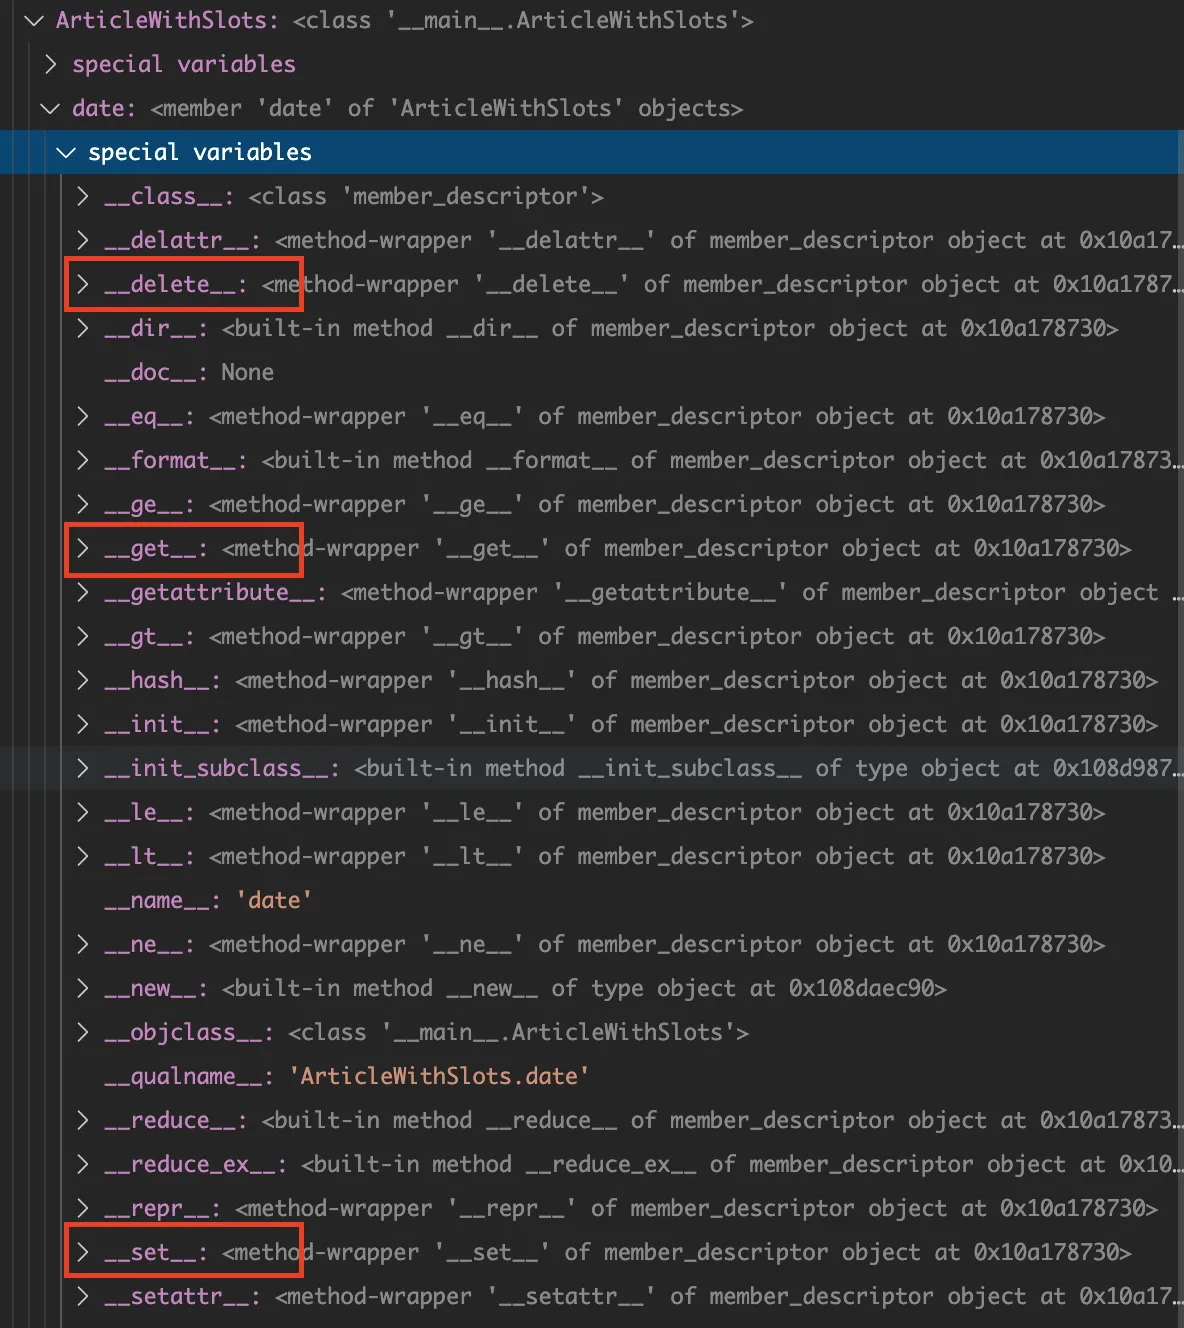

## ```__slots__``` имеет более быстрый доступ к атрибутам
В следующем коде я сравниваю время создания объекта и время доступа к атрибутам для Article и ArticleWithSlots. ```__slots__``` примерно на 10% быстрее.

In [37]:
from functools import wraps
import time

# Decorator 
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

@timeit
def create_object(cls, size):
    for _ in range(size):
        article = cls("2020-01-01", "xiaoxu")

create_object(Article, 1000000)
# 0.755430193 seconds
create_object(ArticleWithSlots, 1000000)
# 0.6753360239999999 seconds

@timeit
def access_attribute(obj, size):
    for _ in range(size):
        writer = obj.writer
        
article = Article("2020-01-01", "xiaoxu")
article_slots = ArticleWithSlots("2020-01-01", "xiaoxu")
access_attribute(article, 1000000)
# 0.06791842000000003 seconds
access_attribute(article_slots, 1000000)
# 0.06492474199999987 seconds

Function create_object(<class '__main__.Article'>, 1000000) {} Took 0.1047 seconds
Function create_object(<class '__main__.ArticleWithSlots'>, 1000000) {} Took 0.0839 seconds
Function access_attribute(<__main__.Article object at 0x10644e690>, 1000000) {} Took 0.0147 seconds
Function access_attribute(<__main__.ArticleWithSlots object at 0x106048160>, 1000000) {} Took 0.0152 seconds


Производительность ```__slots__``` немного выше, потому что временная сложность операций get/set в списке(list) быстрее, чем в словаре(dict) в худшем случае. Поскольку O(n) имеет место только в худшем случае, мы не заметим разницы большую часть времени, особенно когда у вас небольшой объем данных.

## ```__slots__``` уменьшает использование оперативной памяти
Поскольку к атрибутам можно обращаться как к членам данных (как к свойствам), нет необходимости хранить их в словаре ```__dict__```. На самом деле, ```__slots__``` вообще запрещает создание ```__dict__```. Поэтому если вы выведете ```article_slots.__dict__```, вы получите исключение AttributeError.

In [ ]:
article_slots = ArticleWithSlots("2020-01-01", "xiaoxu")
print(article_slots.__dict__)
#AttributeError: 'ArticleWithSlots' object has no attribute '__dict__'

И такое поведение уменьшает использование оперативной памяти объектом. Я сравню размер article и article_slots с помощью pympler. Причина отказа от использования sys.getsizeof() заключается в том, что getsizeof() не учитывает размер ссылающихся объектов. Однако ```__dict__``` - это объект со ссылкой, который будет проигнорирован в getsizeof().

Pympler is a development tool to measure, monitor and analyze the memory behavior of Python objects in a running Python application.

pip install Pympler

pympler.asizeof можно использовать для исследования того, сколько памяти потребляют определенные объекты Python. Рекуррентно. Байты. 

In [14]:
from pympler import asizeof
import sys

a = {"key":"value"}
b = {"key":{"key2":"value"}}

print(sys.getsizeof(a))
# 248
print(sys.getsizeof(b))
# 248
print(asizeof.asizeof(a))
# 360
print(asizeof.asizeof(b))
# 664

184
184
296
536


Как мы видим, sys.getsizeof возвращает в обоих случаях 184 байта. Применим для наших экземпляров.

In [17]:
from pympler import asizeof

article = Article("2020-01-01", "xiaoxu")
article_slots = ArticleWithSlots("2020-01-01", "xiaoxu")

print(asizeof.asizeof(article))
# 416
print(asizeof.asizeof(article_slots))
# 184

384
168


Оказалось, что article_slots экономит более 50% памяти. Вот это да, такое потрясающее улучшение! Такая хорошая производительность объясняется тем, что article_slots не имеет атрибута ```__dict__```, что фактически экономит много памяти.

## Когда использовать и не использовать ```__slots__```?
Пока что кажется, что ```__slots__``` - это очень хорошая функция. Можем ли мы добавить ее в каждый класс?
Ответ - НЕТ! Очевидно, есть некоторые компромиссы.

 - Фиксированные атрибуты
 
Одной из причин использования ```__dict__``` является его гибкость после создания объекта, когда вы можете добавлять новые атрибуты. Однако __slots__ фиксирует атрибуты при создании класса. Таким образом, добавить новые атрибуты позже будет невозможно.

In [ ]:
article_slots = ArticleWithSlots("2020-01-01", "xiaoxu")
article_slots.reviewer = "jojo" # Trying to add new attribute
# AttributeError: 'ArticleWithSlots' object has no attribute 'reviewer'

Но ...

В некоторых случаях вы хотите использовать преимущества ```__slots__```, а также иметь гибкость добавления новых атрибутов во время выполнения. Вы можете добиться этого, добавив ```__dict__``` внутрь ```__slots__``` в качестве атрибута. В ```__dict__``` будут отображаться только новые добавленные атрибуты. Это может быть полезно, когда ваш класс имеет 10+ фиксированных атрибутов, а позже вы захотите добавить 1-2 динамических атрибута.

In [19]:
class ArticleWithSlotsAndDict:
    __slots__ = ["date", "writer", "__dict__"]

    def __init__(self, date, writer):
        self.date = date
        self.writer = writer
        

article_slots_dict = ArticleWithSlotsAndDict("2020-01-01", "xiaoxu")
print(article_slots_dict.__dict__)
# {}
article_slots_dict.reviewer = "jojo"
print(article_slots_dict.__dict__)
# {'reviewer': 'jojo'}

{}
{'reviewer': 'jojo'}


## Наследование

Если вы хотите наследовать класс, включающий ```__slots__```, не нужно повторять эти атрибуты в подклассе. В противном случае подкласс будет занимать больше места. Кроме того, повторяющиеся атрибуты будут недоступны в родительском классе.

In [29]:
class ArticleBase:
    __slots__ = ["date", "writer"]

class ArticleAdvanced(ArticleBase):
    __slots__ = ["reviewer"]

article = ArticleAdvanced()
article.writer = "xiaoxu"
article.reviewer = "jojo"
print(ArticleBase.writer.__get__(article))
# xiaoxu
print(article.writer)
# xiaoxu
print(ArticleAdvanced.reviewer.__get__(article)) # <-- атрибут доступен
# jojo

xiaoxu
xiaoxu
jojo


Вы также можете добавить атрибут ```__dict__``` в подкласс. Или не добавлять ```__slots__``` в подкласс, он по умолчанию будет иметь ```__dict__```.

In [30]:
class ArticleBase:
    __slots__ = ["date", "writer"]

class ArticleAdvanced(ArticleBase):
    __slots__ = ["__dict__"]

article = ArticleAdvanced()
article.reviewer = "jojo"
# {'reviewer': 'jojo'}

class ArticleAdvancedWithoutSlots(ArticleBase):
    pass

article = ArticleAdvancedWithoutSlots()
article.reviewer = "jojo"
print(article.__dict__)
# {'reviewer': 'jojo'}

{'reviewer': 'jojo'}


Область действия слотов ограничено классом, в котором они определены, поэтому наследники (если конечно они не определили собственные слоты) будут иметь ```__dict__```. 
Если наследники тоже определяют слоты, то в перечислении должны содержаться лишь дополнительные. В последующих версиях возможно будет реализована проверка на совпадение имён.

Если вы наследуете класс без ```__slots__```, то подкласс будет содержать ```__dict__```.

In [ ]:
class Article:
    pass

class ArticleWithSlots(Article):
    __slots__ = ["date", "writer"]

article = ArticleWithSlots()
article.writer = "xiaoxu"
article.reviewer = "jojo"
print(article.__dict__)
# {'reviewer': 'jojo'}

Если необходим slots, как родителя, то в наследнике можно прписать ```__slots__ = []```

Попытки определить ```__slots__``` для класса, наследующегося от родителя, не имеющего ```__slots__``` не имеют смысла, по причине того что родителем будет создан ```__dict__```.

## Как работает ```__slots__``` с property

In [40]:
class Point2D:
    __slots__ = ('x', 'y', '__length')
 
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.__length = (x*x + y*y) ** 0.5 # расстояние до точки (относительно нуля):

    @property
    def length(self):
        return self.__length
 
    @length.setter
    def length(self, value):
        self.__length = value

pt = Point2D(1, 2)
print(pt.length)


2.23606797749979


Смотрите, мы здесь обращаемся к свойству length, хотя в __slots__ нет такого разрешенного имени. И при этом нет никаких ошибок выполнения. В принципе, так и должно быть, потому что length – это не локальная переменная экземпляра класса, а атрибут класса Point2D. Коллекция __slots__ не накладывает ограничения на атрибуты класса, только на локальные атрибуты его экземпляров. Благодаря этому и появляется свойство length, которое работает как геттер и сеттер класса Point2D.

## Плюсы
```__slots__``` может быть определенно полезен, когда вы испытываете давление на использование памяти. Его очень легко добавить или удалить всего одной строкой кода. Возможность иметь ```__dict__``` в качестве атрибута в ```__slots__``` дает разработчикам больше гибкости в управлении атрибутами, заботясь при этом о производительности.

## Минусы
Вы должны четко понимать, что вы делаете и чего хотите добиться с помощью ```__slots__```, особенно при наследовании класса с ним. Порядок наследования, имена атрибутов могут иметь огромное значение для производительности.

Непустой ```__slots__``` не может быть использован для классов, наследующихся от встроенных типов переменной длины, например long, str и кортеж. Кроме того, вы не можете присвоить атрибутам в ```__slots__``` значение по умолчанию. Это связано с тем, что эти атрибуты должны быть дескрипторами. Вместо этого вы можете присвоить значение по умолчанию в ```__init__()```.

In [ ]:
class ArticleNumber(int):
    __slots__ = ["number"]
# TypeError: nonempty __slots__ not supported for subtype of 'int'

class Article:
    __slots__ = ["date", "writer"]
    date = "2020-01-01"
# ValueError: 'date' in __slots__ conflicts with class variable

## Резюмируем:

- Ограничение создаваемых локальных свойств.
- Уменьшение занимаемой памяти
- Ускорение работы с локальными свойствами